In [90]:
import pandas as pd
import numpy as np
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve,auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as Data

In [91]:
ROOT = 'flowers'
dirs=os.listdir(ROOT)
dirs

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [92]:
classes = {'daisy':[1,0,0,0,0], 'dandelion':[0,1,0,0,0], 'rose':[0,0,1,0,0], 'sunflower':[0,0,0,1,0], 'tulip':[0,0,0,0,1]}
img_data_array=[]
class_name=[]
for PATH in dirs:
    for file in os.listdir(os.path.join(ROOT, PATH)):
        image_path=os.path.join(ROOT,PATH,file)
        image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float64')
        image /= 255 
        if len(image.shape) == 3:
            img_data_array.append(image.reshape([3, 200, 200]))
            class_name.append(classes[PATH])
img_data=np.array(img_data_array)
img_class=np.array(class_name)

In [93]:
x_trainval,x_test, y_trainval,y_test = train_test_split(img_data,img_class ,test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val=train_test_split(x_trainval,y_trainval,test_size=0.2,random_state=42)

In [94]:
print("Train: {}\nTrainClass: {}\nTest: {}\nTestClass: {}\nVal: {}\nValClass: {}"
      .format(x_train.shape,y_train.shape,x_test.shape,y_test.shape,x_val.shape,y_val.shape))

Train: (2762, 3, 200, 200)
TrainClass: (2762, 5)
Test: (864, 3, 200, 200)
TestClass: (864, 5)
Val: (691, 3, 200, 200)
ValClass: (691, 5)


In [95]:
x_train

array([[[[0.8       , 0.        , 0.79607843, ..., 0.79607843,
          0.8       , 0.        ],
         [0.79607843, 0.8       , 0.        , ..., 0.        ,
          0.79607843, 0.8       ],
         [0.        , 0.79607843, 0.8       , ..., 0.8       ,
          0.        , 0.79607843],
         ...,
         [0.21176471, 0.54509804, 0.61176471, ..., 0.81960784,
          0.11764706, 0.81960784],
         [0.82352941, 0.12156863, 0.82352941, ..., 0.74901961,
          0.49411765, 0.18431373],
         [0.66666667, 0.20392157, 0.05882353, ..., 0.19607843,
          0.36862745, 0.45098039]],

        [[0.29803922, 0.55686275, 0.4627451 , ..., 0.82352941,
          0.12156863, 0.82352941],
         [0.81960784, 0.12941176, 0.82352941, ..., 0.70980392,
          0.29411765, 0.12941176],
         [0.54901961, 0.08235294, 0.01568627, ..., 0.3372549 ,
          0.61568627, 0.56078431],
         ...,
         [0.58039216, 0.39607843, 0.16078431, ..., 0.44313725,
          0.61176471, 0.5

In [96]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [141]:
model = MLP(hidden_size=100, input_size=3*200*200, output_size=5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [98]:
x_train_tensor=torch.Tensor(x_train)
y_train_tensor=torch.Tensor(y_train)
x_test_tensor=torch.Tensor(x_test)
y_test_tensor=torch.Tensor(y_test)
x_val_tensor=torch.Tensor(x_val)
y_val_tensor=torch.Tensor(y_val)

In [99]:
# Create train dataset
train_dataset = Data.TensorDataset(x_train_tensor, y_train_tensor)
# Create test dataset
test_dataset = Data.TensorDataset(x_test_tensor, y_test_tensor)
# Create validation dataset
val_dataset = Data.TensorDataset(x_val_tensor, y_val_tensor)


In [142]:
# Define batch size
batch_size = 10
# Create train data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# Create validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [143]:
print("Train: {}\nTrainClass: {}\nTest: {}\nTestClass: {}\nVal: {}\nValClass: {}"
      .format(x_train_tensor.shape,y_train_tensor.shape,x_test_tensor.shape,y_test_tensor.shape,x_val_tensor.shape,y_val_tensor.shape))

Train: torch.Size([2762, 3, 200, 200])
TrainClass: torch.Size([2762, 5])
Test: torch.Size([864, 3, 200, 200])
TestClass: torch.Size([864, 5])
Val: torch.Size([691, 3, 200, 200])
ValClass: torch.Size([691, 5])


In [145]:
# Initialize best accuracy and corresponding model state
best_accuracy = 0.0
best_model_state = None

# Training loop
num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        labels=torch.argmax(labels,dim=1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            labels=torch.argmax(labels,dim=1)
            test_loss += criterion(output, labels).item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f"Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Check if current accuracy is better than the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()

# Save the best model state dictionary
torch.save(best_model_state, 'best_model_state.pt')


Epoch 1: Test Loss: 0.1405, Accuracy: 0.3762
Epoch 2: Test Loss: 0.1322, Accuracy: 0.4109
Epoch 3: Test Loss: 0.1399, Accuracy: 0.3924
Epoch 4: Test Loss: 0.2124, Accuracy: 0.2419
Epoch 5: Test Loss: 0.1378, Accuracy: 0.3646
Epoch 6: Test Loss: 0.1337, Accuracy: 0.4375
Epoch 7: Test Loss: 0.1383, Accuracy: 0.4167
Epoch 8: Test Loss: 0.1423, Accuracy: 0.3750
Epoch 9: Test Loss: 0.1340, Accuracy: 0.4259
Epoch 10: Test Loss: 0.1402, Accuracy: 0.4583
Epoch 11: Test Loss: 0.3056, Accuracy: 0.2188
Epoch 12: Test Loss: 0.1338, Accuracy: 0.4560
Epoch 13: Test Loss: 0.1599, Accuracy: 0.3727
Epoch 14: Test Loss: 0.2696, Accuracy: 0.3113
Epoch 15: Test Loss: 0.1976, Accuracy: 0.3692
Epoch 16: Test Loss: 0.1460, Accuracy: 0.3993
Epoch 17: Test Loss: 0.2103, Accuracy: 0.3738
Epoch 18: Test Loss: 0.1406, Accuracy: 0.4502
Epoch 19: Test Loss: 0.1645, Accuracy: 0.3854
Epoch 20: Test Loss: 0.1375, Accuracy: 0.4537
Epoch 21: Test Loss: 0.1545, Accuracy: 0.4120
Epoch 22: Test Loss: 0.1510, Accuracy: 0.47

In [146]:
# Load the best model state dictionary
model.load_state_dict(torch.load('best_model_state.pt'))

# Evaluation on validation set
model.eval()
predicted_labels = []
true_labels = []
probabilities=[]

with torch.no_grad():
    for images, labels in val_loader:
        output = model(images)
        labels=torch.argmax(labels,dim=1)
        _, predicted = torch.max(output, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
        probabilities.extend(torch.softmax(output, dim=1).tolist())
        

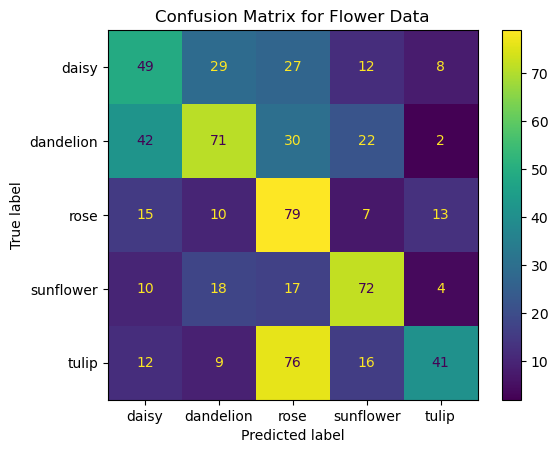

In [147]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.keys())

# Plot the confusion matrix
disp.plot()

# Add a title and show the plot
plt.title("Confusion Matrix for Flower Data")
plt.show()

In [148]:
# Calculate the classification report
report2 = classification_report(true_labels, predicted_labels, target_names=classes.keys())

# Print the report
print(report2)

              precision    recall  f1-score   support

       daisy       0.38      0.39      0.39       125
   dandelion       0.52      0.43      0.47       167
        rose       0.34      0.64      0.45       124
   sunflower       0.56      0.60      0.58       121
       tulip       0.60      0.27      0.37       154

    accuracy                           0.45       691
   macro avg       0.48      0.46      0.45       691
weighted avg       0.49      0.45      0.45       691



In [149]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.4515195369030391
Precision: 0.48851537659811073
Recall: 0.4515195369030391
F1 Score: 0.44646288074220264


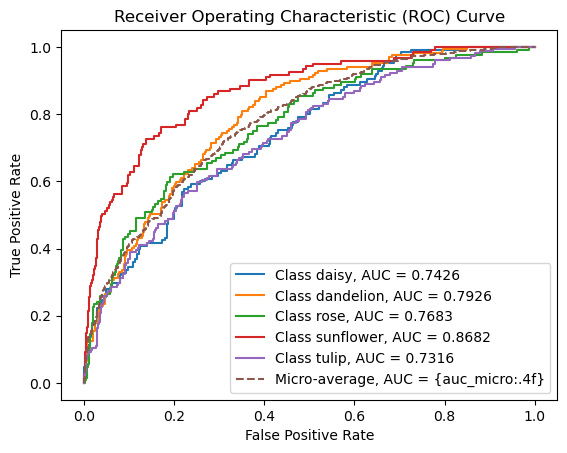

In [150]:
# Convert the predicted labels and true labels to numpy arrays
predictedLabels = np.array(predicted_labels)
trueLabels = np.array(true_labels)
probs=np.array(probabilities)

# Compute the one-hot encoded true labels
one_hot_true_labels = np.eye(5)[trueLabels]  # 5 is number of classes

# Compute the false positive rate, true positive rate, and thresholds for each class
fpr = dict()
tpr = dict()
thresholds = dict()
auc_scores = dict()

for i in range(5):
    fpr[i], tpr[i], thresholds[i] = roc_curve(one_hot_true_labels[:, i], probs[:, i])
    auc_scores[i] = auc(fpr[i], tpr[i])

# Compute the micro-average false positive rate, true positive rate, and AUC
fpr_micro, tpr_micro, _ = roc_curve(one_hot_true_labels.ravel(), probs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Plot the ROC curves for each class
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {list(classes.keys())[i]}, AUC = {auc_scores[i]:.4f}')

# Plot the micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label='Micro-average, AUC = {auc_micro:.4f}', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()